In [351]:
#pip install category_encoders

In [352]:
import pandas as pd
import joblib
import warnings
import time
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import CatBoostEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score
from sklearn import set_config
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [353]:
df   = pd.read_csv('dataset-train.csv')
df_s = pd.read_csv('dataset-test.csv')  #This dataset contains part of the full dataset

In [354]:
df.head()

,ItemLastMill,PackingType,attrCNC,Construction,DecVeneer,Drawing,EdgeColor,EdgeProc,Edges,FilmColor,FilmLogo,FilmMat,FilmWeight,Finishing,FinishingColor,FinishingType,Glossiness,Glue,Grades,JointLayout,Laminated,Machining,OtherMachining,OverlayColor,OverlayMark,OverlayMat,OverlayPress,PlyGrade,SpecReq,TradeMark,Productname008,Model008,Code008,CustomerAccount,MonthNum,Qty,Thickness,Width,PlyLength,GrossActualKg
0,K,KTB0CP,N,-,-/-,-,d.br.,-,standard,d.br./d.br.,-/-,phenolic film/phenolic film,220/220,N,-/-,-/-,-/-,EXT,F II/F II,-/-,Y,N,N,-/-,-/-,-/-,N,LamWG/LamWG,-,RIGA FORM,-,-,-,-,1,18,18.0,2750,1250,838.003
1,F,FKB0CH,N,30_spec-14,-/-,-,-,-,soft,d.br./d.br.,-/-,phenolic film/phenolic film,240/120,N,-/-,-/-,-/-,EXT,W I/F I,-/-,Y,N,N,-/-,-/-,-/-,N,LamWG/LamWG,-,RIGA TEX,-,-,-,-,1,20,30.0,2550,1560,1710.000
2,F,FKB0CH,N,30_spec-14,-/-,-,-,-,soft,d.br./d.br.,-/-,phenolic film/phenolic film,240/120,N,-/-,-/-,-/-,EXT,W I/F I,-/-,Y,N,N,-/-,-/-,-/-,N,LamWG/LamWG,-,RIGA TEX,-,-,-,-,1,20,30.0,2550,1560,1714.000
3,F,FKB0CH,N,30_spec-14,-/-,-,-,-,soft,d.br./d.br.,-/-,phenolic film/phenolic film,240/120,N,-/-,-/-,-/-,EXT,W I/F I,-/-,Y,N,N,-/-,-/-,-/-,N,LamWG/LamWG,-,RIGA TEX,-,-,-,-,1,20,30.0,2550,1560,1674.000
4,F,FTB0VP,N,-,-/-,-,d.br.,-,standard,d.br./d.br.,-/-,phenolic film/phenolic film,220/120,N,-/-,-/-,-/-,EXT,W I/F I,-/-,Y,N,N,-/-,-/-,-/-,N,LamWG/LamWG,-,RIGA TEX,-,-,-,D000861,1,35,21.0,2500,1500,1992.000


In [355]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217720 entries, 0 to 217719
Data columns (total 40 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ItemLastMill     217720 non-null  object 
 1   PackingType      217720 non-null  object 
 2   attrCNC          217720 non-null  object 
 3   Construction     217720 non-null  object 
 4   DecVeneer        217720 non-null  object 
 5   Drawing          217720 non-null  object 
 6   EdgeColor        217720 non-null  object 
 7   EdgeProc         217720 non-null  object 
 8   Edges            217720 non-null  object 
 9   FilmColor        217720 non-null  object 
 10  FilmLogo         217720 non-null  object 
 11  FilmMat          217720 non-null  object 
 12  FilmWeight       217720 non-null  object 
 13  Finishing        217720 non-null  object 
 14  FinishingColor   217720 non-null  object 
 15  FinishingType    217720 non-null  object 
 16  Glossiness       217720 non-null  obje

In [356]:
f_label = ['GrossActualKg']

f_float      = ['Thickness']
f_int        = ['Qty', 'Width','PlyLength']
f_object     = df.select_dtypes(include=['object']).columns.tolist()
f_object_int = ['MonthNum']

print(f_label)
print(f_float)
print(f_int)
print(f_object)
print(f_object_int)

['GrossActualKg']
['Thickness']
['Qty', 'Width', 'PlyLength']
['ItemLastMill', 'PackingType', 'attrCNC', 'Construction', 'DecVeneer', 'Drawing', 'EdgeColor', 'EdgeProc', 'Edges', 'FilmColor', 'FilmLogo', 'FilmMat', 'FilmWeight', 'Finishing', 'FinishingColor', 'FinishingType', 'Glossiness', 'Glue', 'Grades', 'JointLayout', 'Laminated', 'Machining', 'OtherMachining', 'OverlayColor', 'OverlayMark', 'OverlayMat', 'OverlayPress', 'PlyGrade', 'SpecReq', 'TradeMark', 'Productname008', 'Model008', 'Code008', 'CustomerAccount']
['MonthNum']


In [357]:
#Description of numeric features in datasource
df[f_float + f_int + f_object_int+ f_label].describe()

,Thickness,Qty,Width,PlyLength,MonthNum,GrossActualKg
count,217720.000000,217720.000000,217720.000000,217720.000000,217720.000000,217720.000000
mean,17.134705,35.576653,2432.060757,1383.865341,6.332101,1385.243253
std,10.457516,34.052669,892.759383,525.892406,3.478004,630.783074
min,0.000000,1.000000,0.000000,0.000000,1.000000,3.400000
25%,12.000000,20.000000,2090.000000,1200.000000,3.000000,877.000000
50%,15.000000,30.000000,2550.000000,1500.000000,6.000000,1350.000000
75%,21.000000,50.000000,3000.000000,1560.000000,9.000000,1924.000000
max,92.000000,1000.000000,4075.000000,3080.000000,12.000000,4000.000000


In [358]:
#Description of categorical features in datasource - prepare
cat_info_all = []

for col in df[f_object].columns:
    cat_name = col
    cat_count = len(df[col].unique())
    #cat_count_dash = df[df[col].str.lower().eq('-')][col].count()
    cat_count_dash = df[col].str.lower().eq('-').sum()
    cat_count_dash2 = df[col].str.lower().eq('-/-').sum()

    cat_top10 = df[col].value_counts().head(10)
    cat_top10_str = "; ".join("\""+cat_top10.index.astype(str)+'\"-'+cat_top10.astype(str))

    cat_info = {
        "Column name":cat_name,
        "Category count":cat_count,
        "Value count with \"-\" category":cat_count_dash,
        "Value count with \"-/-\" category":cat_count_dash2,
        "Top ten categories with value count":cat_top10_str
    }

    cat_info_all.append(cat_info)

cat_info_all_df = pd.DataFrame(cat_info_all)



In [359]:
#Description of categorical features in datasource - print 1
pd.set_option("display.max_colwidth", None)

cat_info_all_df.sort_values('Category count', ascending=False).head(17)

,Column name,Category count,"Value count with ""-"" category","Value count with ""-/-"" category",Top ten categories with value count
5,Drawing,1154,177898,0,"""-""-177898; ""Art. Nr.: 515067118""-3010; ""Art. Nr.: 515064658""-1694; ""A-009207-01""-1273; ""506978""-996; ""LF17_41_a""-913; ""507006""-912; ""Art. Nr.: 515027840 (3)""-840; ""Art. Nr.: 515040605""-821; ""18TB-00008-11-RE-AA""-585"
33,CustomerAccount,841,21085,0,"""-""-21085; ""D000166""-16200; ""D001174""-13247; ""D000018""-10345; ""D001163""-4624; ""D001460""-4585; ""D001058""-3471; ""D000151""-3338; ""D001575""-2996; ""D000814""-2941"
1,PackingType,153,0,0,"""VTB0VP""-45260; ""FTB0VP""-31011; ""FKB0CT""-12501; ""FTB0CP""-10799; ""HBP0VP""-10119; ""HB00VP""-8289; ""FTB0VX""-8094; ""VSB0VP""-6744; ""FKB0CH""-6429; ""FKB00X""-5913"
18,Grades,129,10798,0,"""W I/F I""-59354; ""F I/F I""-38822; ""BB/BB""-31726; ""WT I/F I""-17786; ""-""-10798; ""BB/WG""-6161; ""WG/WG""-5340; ""W II/F II""-5230; ""WGE/WGE""-4659; ""F II/F II""-4563"
24,OverlayMark,103,0,213831,"""-/-""-213831; ""W1000 ST9/W1000 ST9""-744; ""WPC SP1 1F45M R1021/WPC SP1 1F45M R1021""-319; ""WPC SP1 1F45M R7010/WPC SP1 1F45M R7010""-263; ""U999 ST9/U999 ST9""-247; ""Xface/-""-160; ""2902 BK POL/2902 BK POL""-136; ""CODE 90922/-""-134; ""F6463 MAT/F8514""-131; ""H3840 ST9/H3840 ST9""-119"
28,SpecReq,77,174521,0,"""-""-174521; ""M III""-20411; ""unsanded/not repaired""-3095; ""Scattolini""-2516; ""130 on top""-2315; ""Doka""-1905; ""Foil protected""-1844; ""For overlay""-1833; ""Peri""-1718; ""Rekers""-1021"
12,FilmWeight,66,0,74919,"""-/-""-74919; ""120/120""-44216; ""220/220""-44055; ""220/120""-18379; ""240/120""-16939; ""240/240""-4238; ""-/120""-2674; ""-/220""-1724; ""350/220""-1297; ""220/-""-1284"
9,FilmColor,65,0,70163,"""d.br./d.br.""-112518; ""-/-""-70163; ""black/black""-5475; ""s.grey/d.br.""-4930; ""s.grey/s.grey""-4581; ""white/white""-4116; ""-/d.br.""-3987; ""d.br./-""-1956; ""light br./light br.""-1863; ""colorless/colorless""-1730"
31,Model008,61,206922,0,"""-""-206922; ""KRONE 515067118""-3010; ""KRONE 515064658""-1694; ""A-009207-01""-1273; ""KRONE PL IV (2) Art. Nr. 515027840 KIT""-840; ""KRONE 515040605""-821; ""KRONE 515033691""-484; ""KRONE 515027840""-382; ""KRONE coil coverplate 515085587""-181; ""F/F 220 d.br. 2378 x 3278 x18, EXT""-177"
29,TradeMark,50,12761,0,"""RIGA TEX""-68345; ""RIGA FORM""-45051; ""RIGA PLY""-30229; ""RIGA SHIPPLY""-21127; ""RIGA HEKSA PLUS""-16752; ""-""-12761; ""RIGA MEL""-6462; ""RIGA HPL""-2665; ""RIGA LACQUER""-1701; ""RIGA FLOOR GRATING""-1523"


In [360]:
#Description of categorical features in datasource - print 2
cat_info_all_df.sort_values('Category count', ascending=False).tail(17)

,Column name,Category count,"Value count with ""-"" category","Value count with ""-/-"" category",Top ten categories with value count
15,FinishingType,18,0,214045,"""-/-""-214045; ""LC/-""-1112; ""PUV1-INT SWB/-""-929; ""LC/LC""-660; ""LPU-INT/LPU-INT""-418; ""PUV3-INT/PUV3-INT""-228; ""LPU-INT/-""-188; ""LUV/LUV""-41; ""PUV2-INT/PUV2-INT""-24; ""CC-INT/CC-INT""-21"
6,EdgeColor,17,92431,0,"""d.br.""-96065; ""-""-92431; ""grey""-8990; ""black""-4752; ""white""-4331; ""c.less""-3284; ""l.br.""-1659; ""green""-1542; ""red""-1243; ""l.grey""-1084"
25,OverlayMat,14,0,213447,"""-/-""-213447; ""HPL/HPL""-2396; ""PF/PF""-728; ""-/BL""-383; ""PPL/PPL""-246; ""HPL/-""-245; ""PPL/-""-157; ""PF/-""-47; ""-/PPL""-32; ""HPL/BL""-24"
7,EdgeProc,13,210956,0,"""-""-210956; ""Drawing short edges""-3312; ""Drawing long and short edges""-1620; ""Drawing long edges""-1533; ""H-TG1, 4 edges""-85; ""H-TG1, 2 long edges""-69; ""H-TG2, 2 long edges""-45; ""H-TG2, 4 edges""-38; ""H-G4, 2 long edges""-36; ""H-L, 4 edges, 1 side""-11"
4,DecVeneer,13,0,216575,"""-/-""-216575; ""birch AB/-""-349; ""American white oak AB/American white oak AB""-323; ""birch AB/birch AB""-295; ""American black walnut AB/American black walnut AB""-62; ""birch AB/birch B""-49; ""birch AB/birch A""-30; ""European oak AB/-""-22; ""white ash AB/-""-8; ""pine A/-""-4"
19,JointLayout,11,0,216576,"""-/-""-216576; ""quarter, book match, 180 deg/quarter, book match, 180 deg""-388; ""unjointed/-""-274; ""unjointed/unjointed""-265; ""quarter, book match, 180 deg/-""-100; ""crown, book match, 180 deg/crown, book match, 180 deg""-64; ""unjointed/slipmatch, 2 joints""-30; ""quarter, book match, 180 deg, min 20 cm/quarter, book match, 180 deg""-12; ""mismatch/-""-7; ""crown, book match, 180 deg/-""-3"
16,Glossiness,9,0,215222,"""-/-""-215222; ""25%/-""-1171; ""25%/25%""-657; ""5%/5%""-416; ""5%/-""-159; ""10%/-""-88; ""10%/10%""-5; ""30%/-""-1; ""-/25%""-1"
30,Productname008,7,207043,0,"""-""-207043; ""Floor boards""-9942; ""Construction formwork""-396; ""Coil cover plate""-181; ""FACAL floor""-155; ""Table top""-2; ""Peg board""-1"
0,ItemLastMill,6,0,0,"""F""-96928; ""V""-69520; ""H""-31432; ""T""-18563; ""L""-1273; ""K""-4"
17,Glue,6,10798,0,"""EXT""-180383; ""EXT LN""-16188; ""-""-10798; ""MR""-9981; ""EXT FT""-363; ""EXT AT""-7"


In [361]:
#Prepare train and test dataset 

X = df.drop(f_label, axis=1).copy()
y = df[f_label]

X_s = df_s.drop(f_label, axis=1).copy()
y_s = df_s[f_label]

X_train,   X_test,   y_train,   y_test   = train_test_split(X, y, random_state=17)
X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_s, y_s, random_state=17)

In [362]:
#This code tries to fix the problem with new categorical feature values in test dataset which are not present in training dataset.

#Small dataset
for col in X_s.select_dtypes(include=['object','category']).columns:
    train_categories = set(X_s_train[col].unique())
    test_categories  = set(X_s_test[col].unique())
    missing_in_train = test_categories - train_categories

    if missing_in_train:
        print(f"Warning: {col} has categories in test but not in train: {missing_in_train}")

        for cat in missing_in_train:
            mask = X_s_test[col]==cat
            indices = X_s_test[mask].index[:1]

            X_s_train = pd.concat([X_s_train, X_s_test.loc[indices]])
            y_s_train = pd.concat([y_s_train, y_s_test.loc[indices]])

            X_s_test = X_s_test.drop(indices)
            y_s_test = y_s_test.drop(indices)

print('All done')

#Large dataset
for col in X.select_dtypes(include=['object','category']).columns:
    train_categories = set(X_train[col].unique())
    test_categories  = set(X_test[col].unique())
    missing_in_train = test_categories - train_categories

    if missing_in_train:
        print(f"Warning: {col} has categories in test but not in train: {missing_in_train}")

        for cat in missing_in_train:
            mask = X_test[col]==cat
            indices = X_test[mask].index[:1]

            X_train = pd.concat([X_train, X_test.loc[indices]])
            y_train = pd.concat([y_train, y_test.loc[indices]])

            X_test = X_test.drop(indices)
            y_test = y_test.drop(indices)

print('All done')

All done
All done


In [363]:
# We will use CatBoostEncoder with tree-based models, so there is no need for scaling values
col_transformer = make_column_transformer(
    (CatBoostEncoder(), f_object), 
    remainder = 'passthrough'
)

In [364]:
X_train_transformed = pd.DataFrame(col_transformer.fit_transform(X_train, y_train), columns=col_transformer.get_feature_names_out())
X_test_transformed = pd.DataFrame(col_transformer.fit_transform(X_test, y_test), columns=col_transformer.get_feature_names_out())
print(f"Shape of the transformed large train dataset: {X_train_transformed.shape}")
print(f"Shape of the transformed large test dataset: {X_test_transformed.shape}")

Shape of the transformed large train dataset: (163411, 39)
Shape of the transformed large test dataset: (54309, 39)


In [365]:
#Smaller dataset will not be used
#X_s_train_transformed = pd.DataFrame(col_transformer.fit_transform(X_s_train, y_s_train), columns=col_transformer.get_feature_names_out())
#X_s_test_transformed = pd.DataFrame(col_transformer.fit_transform(X_s_test, y_s_test), columns=col_transformer.get_feature_names_out())
#print(f"Shape of the transformed small train dataset: {X_s_train_transformed.shape}")
#print(f"Shape of the transformed small test dataset: {X_s_test_transformed.shape}")

In [ ]:
#Training statistics will be saved
training_results = []

def append_training_results(atr_name, atr_model, atr_time):
    atr_y_test_preds = atr_model.predict(X_test_transformed)

    atr_mse = mean_squared_error(y_test, atr_y_test_preds)
    atr_r2 = r2_score(y_test, atr_y_test_preds)
    atr_rmse = root_mean_squared_error(y_test, atr_y_test_preds)
    atr_mae = mean_absolute_error(y_test, atr_y_test_preds)
    atr_meae = median_absolute_error(y_test, atr_y_test_preds)
    atr_ev = explained_variance_score(y_test, atr_y_test_preds)

    print(atr_name)
    print(f"mean squared error {atr_mse:.4f}")
    print(f"r2 score {atr_r2:.4f}")
    print(f"root mean squared error {atr_rmse:.4f}")
    print(f"mean absolute error {atr_mae:.4f}")
    print(f"median absolute error {atr_meae:.4f}")
    print(f"explained variance {atr_ev:.4f}")

    print(f"Fit time (seconds) {atr_time:.2f}")
    print("Hyperparameters :", {k: v for k, v in atr_model.get_params().items() if v is not None})

    training_results.append(
        {
            "Model type":atr_name,
            "Mean squared error":round(atr_mse,4),
            "R2 score":round(atr_r2,4),
            "Root mean squared error":round(atr_rmse,4),
            "Mean absolute error":round(atr_mae,4),
            "Median absolute error":round(atr_meae,4),
            "Explained variance":round(atr_ev,4),
            "Fit time (seconds)":round(atr_time,0),
            "Hyperparameters":{k: v for k, v in atr_model.get_params().items() if v is not None}
        }
    )
    

In [367]:
#Append data from Azure server which will be used for comparison
training_results.append(
    {
        "Model type":"Azure model",
        "Mean squared error":0,
        "R2 score":0.99497,
        "Root mean squared error":42.634,
        "Mean absolute error":25.794,
        "Median absolute error":14.795,
        "Explained variance":0.99498,
        "Fit time (seconds)":0,
        "Hyperparameters":""
    }
)

## Train DecisionTreeRegressor

#### Simple DecisionTreeRegressor model

In [368]:
time_a = time.perf_counter()
model_dtr1 = DecisionTreeRegressor( random_state=17)
model_dtr1.fit(X_train_transformed, y_train)
dtr1_time_b   = time.perf_counter() - time_a

append_training_results("Decision Tree Regressor", model_dtr1, dtr1_time_b)

Decision Tree Regressor
mean squared error 9587.5507
r2 score 0.9760
root_mean_squared_error 97.9160
mean absolute error 47.3430
median absolute error 20.0000
explained variance 0.9760
Fit time (seconds) 11.58
Hyperparameters : {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 17, 'splitter': 'best'}


#### DecisionTreeRegressor with GridSearchCV

In [369]:
param_grid = {
    'max_depth': [20, 30, 50],
    'max_leaf_nodes': [1000, 5000, 10000],
    'min_impurity_decrease': [0.0, 0.001],
    'ccp_alpha': [0.0, 0.001]
}


search_model_dtr2 = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=17),
    param_grid=param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    verbose=1,
    n_jobs=-1
)


pipe_model_dtr2 = Pipeline([
    ('transformer', col_transformer),
    ('model_sarch', search_model_dtr2)
])

time_a = time.perf_counter()
pipe_model_dtr2.fit(X_train, y_train)
dtr2_time_b   = time.perf_counter() - time_a

model_dtr2_best = search_model_dtr2.best_estimator_

append_training_results("DecisionTreeRegressor with GridSearchCV", model_dtr2_best, dtr2_time_b)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
DecisionTreeRegressor with GridSearchCV
mean squared error 7883.3104
r2 score 0.9802
root_mean_squared_error 88.7880
mean absolute error 41.1867
median absolute error 19.2318
explained variance 0.9803
Fit time (seconds) 102.02
Hyperparameters : {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 30, 'max_leaf_nodes': 5000, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 17, 'splitter': 'best'}


## Train ExtraTreesRegressor

#### Simple ExtraTreesRegressor model

In [370]:
pipe_model_dtr3 = Pipeline([
    ('transformer', col_transformer),
    ('model', ExtraTreesRegressor(random_state=17, verbose=1, n_jobs=-1))
])

time_a = time.perf_counter()
pipe_model_dtr3.fit(X_train, y_train)
dtr3_time_b   = time.perf_counter() - time_a

model_dtr3 = pipe_model_dtr3.named_steps['model']

append_training_results("ExtraTreesRegressor", model_dtr3, dtr3_time_b)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


ExtraTreesRegressor
mean squared error 2649.9327
r2 score 0.9934
root_mean_squared_error 51.4775
mean absolute error 28.2501
median absolute error 16.2600
explained variance 0.9934
Fit time (seconds) 32.04
Hyperparameters : {'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_features': 1.0, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 17, 'verbose': 1, 'warm_start': False}


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.3s finished


#### ExtraTreesRegressor with GridSearchCV

In [372]:
'''
param_grid = {
    'n_estimators': [100, 200, 300],
    'bootstrap': [False, True],
    'ccp_alpha': [0.0, 0.001, 0.01, 0.1]
}
'''

param_grid = {
    'n_estimators': [100, 200, 300],
}

search_model_dtr4 = GridSearchCV(
    estimator=ExtraTreesRegressor(random_state=17, verbose=1, n_jobs=-1),
    param_grid=param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    verbose=1,
    n_jobs=-1
)


pipe_model_dtr4 = Pipeline([
    ('transformer', col_transformer),
    ('model_sarch', search_model_dtr4)
])

time_a = time.perf_counter()
pipe_model_dtr4.fit(X_train, y_train)
dtr4_time_b   = time.perf_counter() - time_a

model_dtr4_best = search_model_dtr4.best_estimator_

append_training_results("ExtraTreesRegressor with GridSearchCV", model_dtr4_best, dtr4_time_b)


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


ExtraTreesRegressor with GridSearchCV
mean squared error 2649.9327
r2 score 0.9934
root_mean_squared_error 51.4775
mean absolute error 28.2501
median absolute error 16.2600
explained variance 0.9934
Fit time (seconds) 248.71
Hyperparameters : {'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_features': 1.0, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 17, 'verbose': 1, 'warm_start': False}


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.3s finished


## Train Random Forest Regressor

In [373]:
pipe_model_dtr5 = Pipeline([
    ('transformer', col_transformer),
    ('model', RandomForestRegressor(
        n_estimators=100,
        max_depth=30,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features='sqrt',
        random_state=17, verbose=1, n_jobs=-1))
])
time_a = time.perf_counter()
pipe_model_dtr5.fit(X_train, y_train)
dtr5_time_b   = time.perf_counter() - time_a

model_dtr5 = pipe_model_dtr5.named_steps['model']

append_training_results("RandomForestRegressor", model_dtr5, dtr5_time_b)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s


RandomForestRegressor
mean squared error 23438.5596
r2 score 0.9412
root_mean_squared_error 153.0966
mean absolute error 94.5136
median absolute error 52.4725
explained variance 0.9414
Fit time (seconds) 18.07
Hyperparameters : {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 30, 'max_features': 'sqrt', 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 17, 'verbose': 1, 'warm_start': False}


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


## Train XGBOOST regressor

### Starting position with XGBoost - regressor with suggested parametrs

In [374]:

pipe_model_dtr6 = Pipeline([
    ('transformer', col_transformer),
    ('model', XGBRegressor(
        n_estimators=1000,           
        max_depth=8,                
        learning_rate=0.05,         
        subsample=0.8,              
        colsample_bytree=0.8,       
        colsample_bylevel=0.8,      
        min_child_weight=3,         
        gamma=0.1,                  
        reg_alpha=0.1,              
        reg_lambda=1,               
        random_state=17,
        n_jobs=-1,
        tree_method='hist',         
        eval_metric='rmse'
        ))
])

time_a = time.perf_counter()
pipe_model_dtr6.fit(X_train, y_train)
dtr6_time_b   = time.perf_counter() - time_a

model_dtr6 = pipe_model_dtr6.named_steps['model']

append_training_results("XGBRegressor - initial model", model_dtr6, dtr6_time_b)


XGBRegressor - initial model
mean squared error 2377.9551
r2 score 0.9940
root_mean_squared_error 48.7643
mean absolute error 32.1327
median absolute error 21.8365
explained variance 0.9941
Fit time (seconds) 16.21
Hyperparameters : {'objective': 'reg:squarederror', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'enable_categorical': False, 'eval_metric': 'rmse', 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 3, 'missing': nan, 'n_estimators': 1000, 'n_jobs': -1, 'random_state': 17, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8, 'tree_method': 'hist'}


### Stage 1

In [375]:
param_grid = {
    'n_estimators': [100, 200, 300, 500, 1000, 1500, 2000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [8],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'colsample_bylevel': [0.8],
    'min_child_weight': [3],
    'gamma': [0, 0.1, 0.2, 0.5, 1],
    'reg_alpha': [0.1],
    'reg_lambda': [0.1]
}

search_model_dtr7 = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=17, n_jobs=-1, tree_method='hist'),
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=10,
    random_state=17,
    n_jobs=-1
)

pipe_model_dtr7 = Pipeline([
    ('transformer', col_transformer),
    ('model_search', search_model_dtr7)
])

time_a = time.perf_counter()
pipe_model_dtr7.fit(X_train, y_train)
dtr7_time_b   = time.perf_counter() - time_a

model_dtr7 = pipe_model_dtr7.named_steps['model_search'].best_estimator_

append_training_results("XGBRegressor - Stage 1", model_dtr7, dtr7_time_b)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
XGBRegressor - Stage 1
mean squared error 2330.4902
r2 score 0.9942
root_mean_squared_error 48.2752
mean absolute error 32.1224
median absolute error 21.8976
explained variance 0.9942
Fit time (seconds) 1270.22
Hyperparameters : {'objective': 'reg:squarederror', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'enable_categorical': False, 'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 3, 'missing': nan, 'n_estimators': 2000, 'n_jobs': -1, 'random_state': 17, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8, 'tree_method': 'hist'}


In [376]:
dtr7_n_estimators = search_model_dtr7.best_params_['n_estimators']
dtr7_learning_rate = search_model_dtr7.best_params_['learning_rate']

print("n_estimators:", dtr7_n_estimators)
print("learning_rate:", dtr7_learning_rate)

print("Stage 1 - best parameters:", search_model_dtr7.best_params_)
print("Stage 1 - best parameters:", pipe_model_dtr7.named_steps['model_search'].best_params_)


n_estimators: 2000
learning_rate: 0.05
Stage 1 - best parameters: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 2000, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.8}
Stage 1 - best parameters: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 2000, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.8}


### Stage 2

In [377]:

param_grid = {
    'n_estimators': [dtr7_n_estimators],
    'learning_rate': [dtr7_learning_rate],
    'max_depth': [6, 8, 10, 12],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.5, 1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'colsample_bylevel': [0.8],
    'reg_alpha': [0.1],
    'reg_lambda': [0.1]
}

search_model_dtr8 = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=17, n_jobs=-1, tree_method='hist'),
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=10,
    random_state=17,
    n_jobs=-1
)

pipe_model_dtr8 = Pipeline([
    ('transformer', col_transformer),
    ('model_search', search_model_dtr8)
])

time_a = time.perf_counter()
pipe_model_dtr8.fit(X_train, y_train)
dtr8_time_b   = time.perf_counter() - time_a

model_dtr8 = pipe_model_dtr8.named_steps['model_search'].best_estimator_

append_training_results("XGBRegressor - Stage 2", model_dtr8, dtr8_time_b)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
XGBRegressor - Stage 2
mean squared error 2149.2642
r2 score 0.9946
root_mean_squared_error 46.3602
mean absolute error 31.3926
median absolute error 21.9146
explained variance 0.9946
Fit time (seconds) 2480.02
Hyperparameters : {'objective': 'reg:squarederror', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'enable_categorical': False, 'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 7, 'missing': nan, 'n_estimators': 2000, 'n_jobs': -1, 'random_state': 17, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8, 'tree_method': 'hist'}


In [378]:
dtr8_max_depth = search_model_dtr8.best_params_['max_depth']
dtr8_min_child_weight = search_model_dtr8.best_params_['min_child_weight']
dtr8_gamma = search_model_dtr8.best_params_['gamma']

print("max_depth:", dtr8_max_depth)
print("min_child_weight:", dtr8_min_child_weight)
print("gamma:", dtr8_gamma)

print("Stage 2 - best parameters:", search_model_dtr8.best_params_)
print("Stage 2 - best parameters:", pipe_model_dtr8.named_steps['model_search'].best_params_)

max_depth: 6
min_child_weight: 7
gamma: 0.5
Stage 2 - best parameters: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 2000, 'min_child_weight': 7, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.8}
Stage 2 - best parameters: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 2000, 'min_child_weight': 7, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.8}


### Stage 3

In [379]:
param_grid = {
    'n_estimators': [dtr7_n_estimators],
    'learning_rate': [dtr7_learning_rate],
    'max_depth': [dtr8_max_depth],
    'min_child_weight': [dtr8_min_child_weight],
    'gamma': [dtr8_gamma],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bylevel': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0.1],
    'reg_lambda': [0.1]
}

search_model_dtr9 = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=17, n_jobs=-1, tree_method='hist'),
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=10,
    random_state=17,
    n_jobs=-1
)

pipe_model_dtr9 = Pipeline([
    ('transformer', col_transformer),
    ('model_search', search_model_dtr9)
])

time_a = time.perf_counter()
pipe_model_dtr9.fit(X_train, y_train)
dtr9_time_b   = time.perf_counter() - time_a

model_dtr9 = pipe_model_dtr9.named_steps['model_search'].best_estimator_

append_training_results("XGBRegressor - Stage 3", model_dtr9, dtr9_time_b)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
XGBRegressor - Stage 3
mean squared error 2008.1055
r2 score 0.9950
root_mean_squared_error 44.8119
mean absolute error 30.5204
median absolute error 21.2308
explained variance 0.9950
Fit time (seconds) 1868.20
Hyperparameters : {'objective': 'reg:squarederror', 'colsample_bylevel': 0.8, 'colsample_bytree': 1.0, 'enable_categorical': False, 'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 7, 'missing': nan, 'n_estimators': 2000, 'n_jobs': -1, 'random_state': 17, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.9, 'tree_method': 'hist'}


In [380]:
dtr9_subsample = search_model_dtr9.best_params_['subsample']
dtr9_colsample_bytree = search_model_dtr9.best_params_['colsample_bytree']
dtr9_colsample_bylevel = search_model_dtr9.best_params_['colsample_bylevel']

print("subsample:", dtr9_subsample)
print("colsample_bytree:", dtr9_colsample_bytree)
print("colsample_bylevel:", dtr9_colsample_bylevel)

print("Stage 3 - best parameters:", search_model_dtr9.best_params_)
print("Stage 3 - best parameters:", pipe_model_dtr9.named_steps['model_search'].best_params_)

subsample: 0.9
colsample_bytree: 1.0
colsample_bylevel: 0.8
Stage 3 - best parameters: {'subsample': 0.9, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 2000, 'min_child_weight': 7, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.8}
Stage 3 - best parameters: {'subsample': 0.9, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 2000, 'min_child_weight': 7, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.8}


### Stage 4

In [381]:
param_grid = {
    'n_estimators': [dtr7_n_estimators],
    'learning_rate': [dtr7_learning_rate],
    'max_depth': [dtr8_max_depth],
    'min_child_weight': [dtr8_min_child_weight],
    'gamma': [dtr8_gamma],
    'subsample': [dtr9_subsample],
    'colsample_bytree': [dtr9_colsample_bytree],
    'colsample_bylevel': [dtr9_colsample_bylevel],
    'reg_alpha': [0, 0.01, 0.1, 1, 10],
    'reg_lambda': [0.1, 1, 10, 100]
}

search_model_dtr10 = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=17, n_jobs=-1, tree_method='hist'),
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=10,
    random_state=17,
    n_jobs=-1
)

pipe_model_dtr10 = Pipeline([
    ('transformer', col_transformer),
    ('model_search', search_model_dtr10)
])

time_a = time.perf_counter()
pipe_model_dtr10.fit(X_train, y_train)
dtr10_time_b   = time.perf_counter() - time_a

model_dtr10 = pipe_model_dtr10.named_steps['model_search'].best_estimator_

append_training_results("XGBRegressor - Stage 4 - Final", model_dtr10, dtr10_time_b)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
XGBRegressor - Stage 4 - Final
mean squared error 1989.9937
r2 score 0.9950
root_mean_squared_error 44.6093
mean absolute error 30.1072
median absolute error 20.7174
explained variance 0.9950
Fit time (seconds) 405.82
Hyperparameters : {'objective': 'reg:squarederror', 'colsample_bylevel': 0.8, 'colsample_bytree': 1.0, 'enable_categorical': False, 'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 7, 'missing': nan, 'n_estimators': 2000, 'n_jobs': -1, 'random_state': 17, 'reg_alpha': 0.1, 'reg_lambda': 10, 'subsample': 0.9, 'tree_method': 'hist'}


In [382]:
dtr10_reg_alpha = search_model_dtr10.best_params_['reg_alpha']
dtr10_reg_lambda = search_model_dtr10.best_params_['reg_lambda']

print("reg_alpha:", dtr10_reg_alpha)
print("reg_lambda:", dtr10_reg_lambda)

print("Stage 4 - best parameters:", search_model_dtr10.best_params_)
print("Stage 4 - best parameters:", pipe_model_dtr10.named_steps['model_search'].best_params_)

reg_alpha: 0.1
reg_lambda: 10
Stage 4 - best parameters: {'subsample': 0.9, 'reg_lambda': 10, 'reg_alpha': 0.1, 'n_estimators': 2000, 'min_child_weight': 7, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.8}
Stage 4 - best parameters: {'subsample': 0.9, 'reg_lambda': 10, 'reg_alpha': 0.1, 'n_estimators': 2000, 'min_child_weight': 7, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.8}


### Final model

In [383]:
set_config(transform_output="pandas")

pipe_model_dtr11 = Pipeline([
    ('transformer', col_transformer),
    ('model', XGBRegressor(
        objective='reg:squarederror',   #This should be set automatically in previous modles, added to be sure
        n_estimators=dtr7_n_estimators,  
        learning_rate=dtr7_learning_rate,
        max_depth=dtr8_max_depth,
        min_child_weight=dtr8_min_child_weight,
        gamma=dtr8_gamma,
        subsample=dtr9_subsample,
        colsample_bytree=dtr9_colsample_bytree,
        colsample_bylevel=dtr9_colsample_bylevel,
        reg_alpha=dtr10_reg_alpha,
        reg_lambda=dtr10_reg_lambda,
        random_state=17,
        n_jobs=-1,
        tree_method='hist',    
        eval_metric='rmse'
        ))
])

time_a = time.perf_counter()
pipe_model_dtr11.fit(X_train, y_train, model__eval_set=[(X_train_transformed, y_train),(X_test_transformed, y_test)], model__verbose=False)
dtr11_time_b   = time.perf_counter() - time_a

model_dtr11 = pipe_model_dtr11.named_steps['model']
model_dtr11_results = model_dtr11.evals_result()

#Do not append, is the same as stage 4 model.
#append_training_results("XGBRegressor - Final model", model_dtr11, dtr11_time_b)

In [384]:
print(f"Training error (rmse): {model_dtr11_results['validation_0']['rmse'][-1]}")
print(f"Testing error (rmse): {model_dtr11_results['validation_1']['rmse'][-1]}")

Training error (rmse): 31.766430188199845
Testing error (rmse): 44.60934593772529


In [385]:
model_dtr11.save_model('model_dtr11_best.pkl')

## REPORTING

In [386]:
#Training results
training_results_df = pd.DataFrame(training_results)
training_results_df

,Model type,Mean squared error,R2 score,Root mean squared error,Mean absolute error,Median absolute error,Explained variance,Fit time (seconds),Hyperparameters
0,Azure model,0.0000,0.99497,42.6340,25.7940,14.7950,0.99498,0.0,
1,Decision Tree Regressor,9587.5507,0.97600,97.9160,47.3430,20.0000,0.97600,12.0,"{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 17, 'splitter': 'best'}"
2,DecisionTreeRegressor with GridSearchCV,7883.3104,0.98020,88.7880,41.1867,19.2318,0.98030,102.0,"{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 30, 'max_leaf_nodes': 5000, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 17, 'splitter': 'best'}"
3,ExtraTreesRegressor,2649.9327,0.99340,51.4775,28.2501,16.2600,0.99340,32.0,"{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_features': 1.0, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 17, 'verbose': 1, 'warm_start': False}"
4,ExtraTreesRegressor with GridSearchCV,2649.9327,0.99340,51.4775,28.2501,16.2600,0.99340,249.0,"{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_features': 1.0, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 17, 'verbose': 1, 'warm_start': False}"
5,RandomForestRegressor,23438.5596,0.94120,153.0966,94.5136,52.4725,0.94140,18.0,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 30, 'max_features': 'sqrt', 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 17, 'verbose': 1, 'warm_start': False}"
6,XGBRegressor - initial model,2377.9551,0.99400,48.7643,32.1327,21.8365,0.99410,16.0,"{'objective': 'reg:squarederror', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'enable_categorical': False, 'eval_metric': 'rmse', 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 3, 'missing': nan, 'n_estimators': 1000, 'n_jobs': -1, 'random_state': 17, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8, 'tree_method': 'hist'}"
7,XGBRegressor - Stage 1,2330.4902,0.99420,48.2752,32.1224,21.8976,0.99420,1270.0,"{'objective': 'reg:squarederror', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'enable_categorical': False, 'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 3, 'missing': nan, 'n_estimators': 2000, 'n_jobs': -1, 'random_state': 17, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8, 'tree_method': 'hist'}"
8,XGBRegressor - Stage 2,2149.2642,0.99460,46.3602,31.3926,21.9146,0.99460,2480.0,"{'objective': 'reg:squarederror', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'enable_categorical': False, 'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 7, 'missing': nan, 'n_estimators': 2000, 'n_jobs': -1, 'random_state': 17, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8, 'tree_method': 'hist'}"
9,XGBRegressor - Stage 3,2008.1055,0.99500,44.8119,30.5204,21.2308,0.99500,1868.0,"{'objective': 'reg:squarederror', 'colsample_bylevel': 0.8, 'colsample_bytree': 1.0, 'enable_categorical': False, 'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 7, 'missing': nan, 'n_estimators': 2000, 'n_jobs': -1, 'random_state': 17, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.9, 'tree_method': 'hist'}"


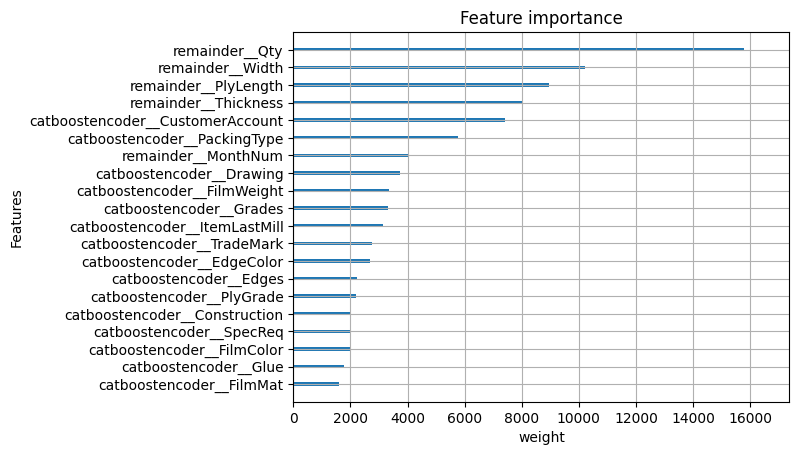

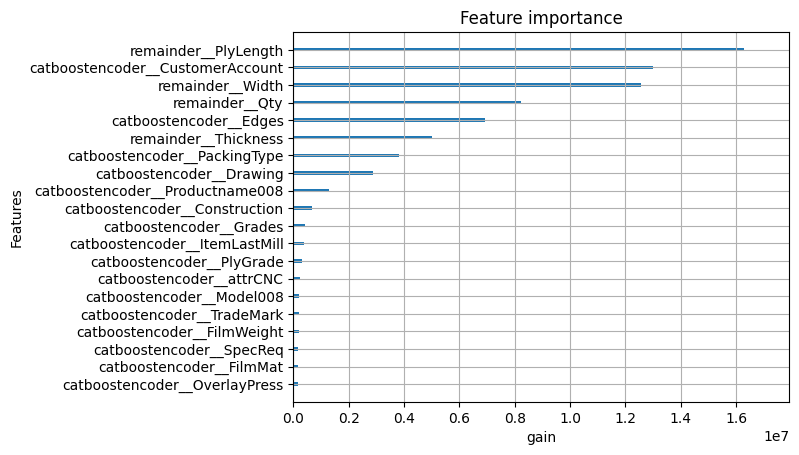

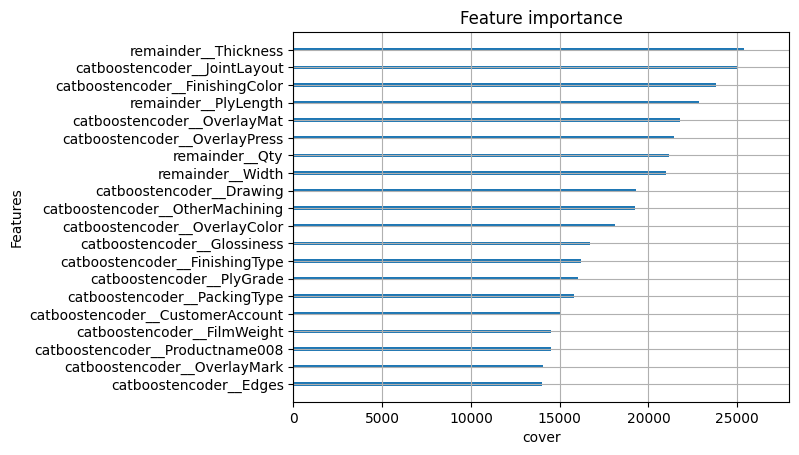

In [387]:
#Feature importance graph
importance_type = ["weight", "gain", "cover"]
for i in importance_type:
    xgb.plot_importance(model_dtr11, importance_type=i, show_values=False, xlabel=i, max_num_features=20)
    plt.show()

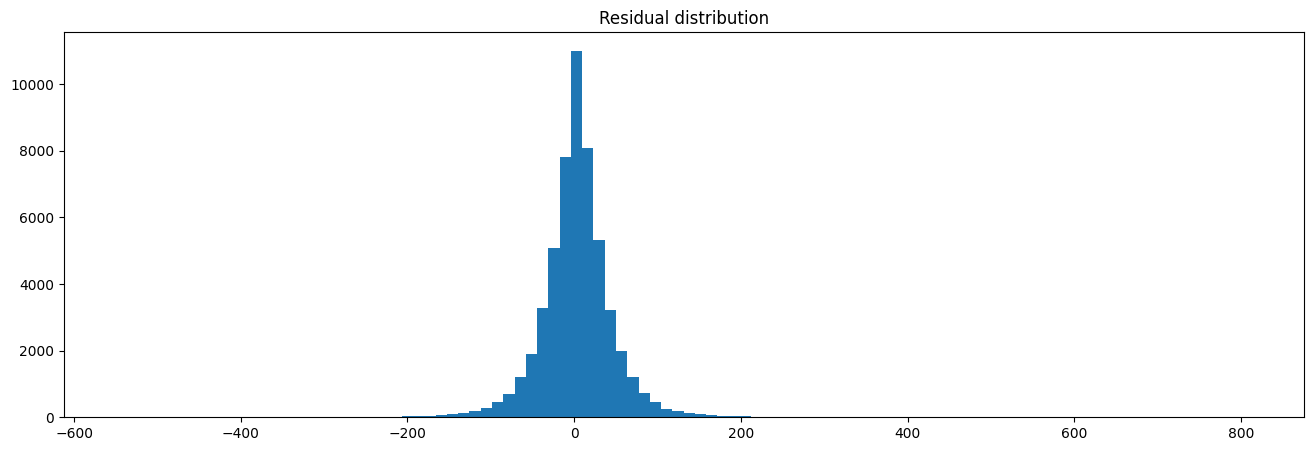

In [388]:
y_test_preds = model_dtr11.predict(X_test_transformed)
plt.figure(figsize=(16,5))
plt.hist(y_test.iloc[:,0] - y_test_preds, bins=100)
plt.title("Residual distribution")
plt.show()

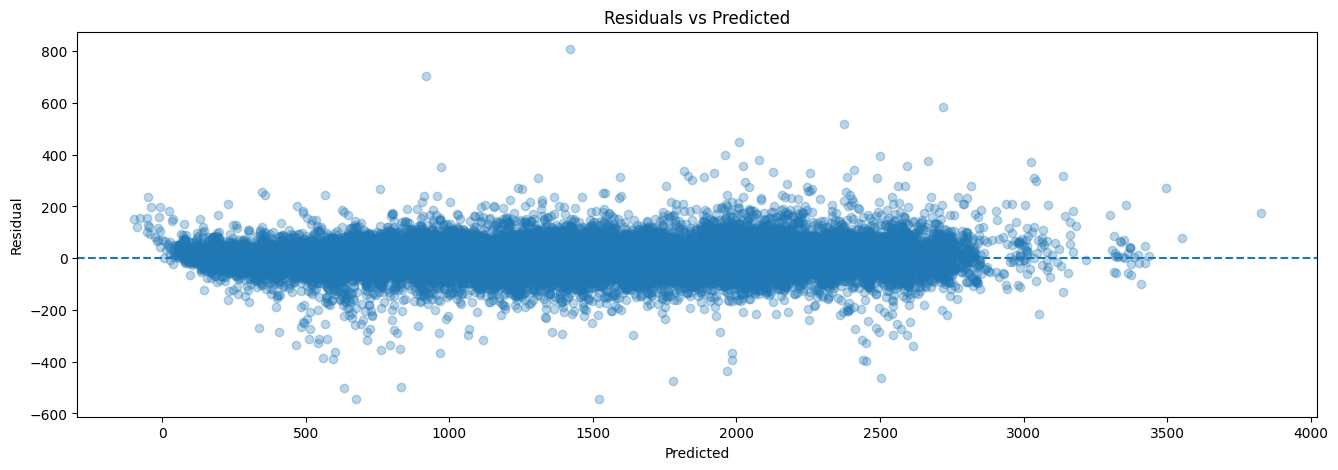

In [389]:
plt.figure(figsize=(16,5))
plt.scatter(y_test_preds, y_test.iloc[:,0] - y_test_preds, alpha=0.3)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted")
plt.show()

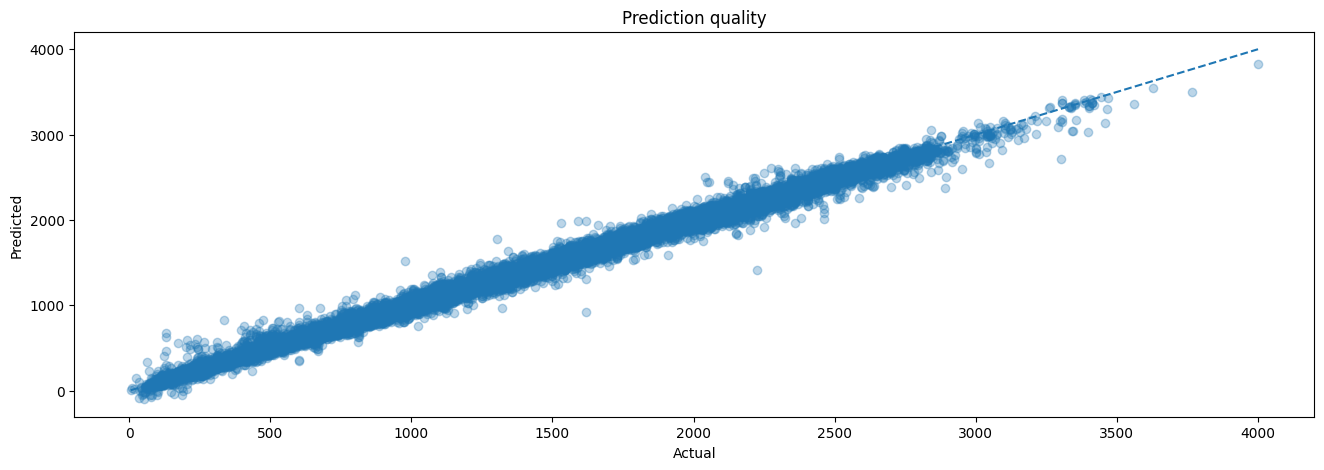

In [390]:
plt.figure(figsize=(16,5))
plt.scatter(y_test.iloc[:,0], y_test_preds, alpha=0.3)
plt.plot([y_test.iloc[:,0].min(), y_test.iloc[:,0].max()], [y_test.iloc[:,0].min(), y_test.iloc[:,0].max()], "--")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Prediction quality")
plt.show()

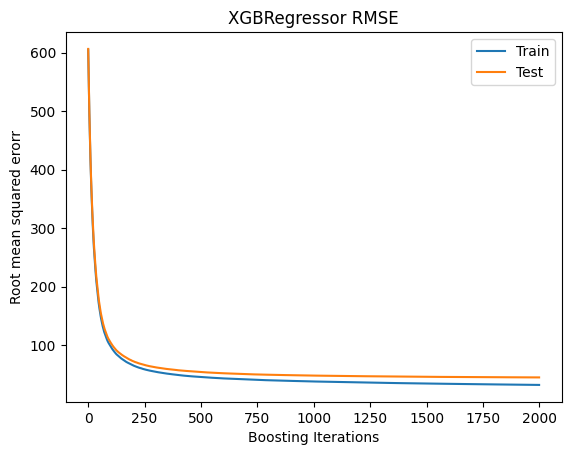

In [391]:
epochs = len(model_dtr11_results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()

ax.plot(x_axis, model_dtr11_results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, model_dtr11_results['validation_1']['rmse'], label='Test')

plt.title('XGBRegressor RMSE')
plt.xlabel("Boosting Iterations")
plt.ylabel("Root mean squared erorr")
plt.legend(loc="upper right");